# Prediction of hotel booking cancellations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import datetime
import calendar
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('bookings.csv')

In [3]:
df

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0       INN00001             2               0                     1   
1       INN00002             2               0                     2   
2       INN00003             1               0                     2   
3       INN00004             2               0                     0   
4       INN00005             2               0                     1   
...          ...           ...             ...                   ...   
36270   INN36271             3               0                     2   
36271   INN36272             2               0                     1   
36272   INN36273             2               0                     2   
36273   INN36274             2               0                     0   
36274   INN36275             2               0                     1   

       no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                      2       Meal Plan 1                           0   
1                      3      Not Selected                           0   
2                      1       Meal Plan 1                           0   
3                      2       Meal Plan 1                           0   
4                      1      Not Selected                           0   
...                  ...               ...                         ...   
36270                  6       Meal Plan 1                           0   
36271                  3       Meal Plan 1                           0   
36272                  6       Meal Plan 1                           0   
36273                  3      Not Selected                           0   
36274                  2       Meal Plan 1                           0   

      room_type_reserved  lead_time  arrival_year  arrival_month  \
0            Room_Type 1        224          2017             10   
1            Room_Type 1          5          2018             11   
2            Room_Type 1          1          2018              2   
3            Room_Type 1        211          2018              5   
4            Room_Type 1         48          2018              4   
...                  ...        ...           ...            ...   
36270        Room_Type 4         85          2018              8   
36271        Room_Type 1        228          2018             10   
36272        Room_Type 1        148          2018              7   
36273        Room_Type 1         63          2018              4   
36274        Room_Type 1        207          2018             12   

       arrival_date market_segment_type  repeated_guest  \
0                 2             Offline               0   
1                 6              Online               0   
2                28              Online               0   
3                20              Online               0   
4                11              Online               0   
...             ...                 ...             ...   
36270             3              Online               0   
36271            17              Online               0   
36272             1              Online               0   
36273            21              Online               0   
36274            30             Offline               0   

       no_of_previous_cancellations  no_of_previous_bookings_not_canceled  \
0                                 0                                     0   
1                                 0                                     0   
2                                 0                                     0   
3                                 0                                     0   
4                                 0                                     0   
...                             ...                                   ...   
36270                             0                                     0   
36271                             0                                     0   
36272                            

In [4]:
df.info()
#Dataset before adding new columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

avg_price_per_room and leadcolumns has values which are very unique, this is hard for doing data analysis, so sorting all the values in well defined slabs is helpful for visualization.

In [5]:
price_slabs = []
for i in range(len(df)):
    if df.iloc[i,16] == 0:
        price_slabs.append(0)
    elif df.iloc[i,16]>0 and df.iloc[i,16] <= 50:
        price_slabs.append(50)
    elif df.iloc[i,16]>50 and df.iloc[i,16] <= 100:
        price_slabs.append(100)
    elif df.iloc[i,16]>100 and df.iloc[i,16] <= 150:
        price_slabs.append(150)
    elif df.iloc[i,16]>150 and df.iloc[i,16] <= 200:
        price_slabs.append(200)
    elif df.iloc[i,16]>200 and df.iloc[i,16] <= 250:
        price_slabs.append(250)
    elif df.iloc[i,16]>250 and df.iloc[i,16] <= 300:
        price_slabs.append(300)
    elif df.iloc[i,16]>300 and df.iloc[i,16] <= 350:
        price_slabs.append(350)
    elif df.iloc[i,16]>350 and df.iloc[i,16] <= 400:
        price_slabs.append(400)
    elif df.iloc[i,16]>400 and df.iloc[i,16] <= 450:
        price_slabs.append(450)
    elif df.iloc[i,16]>450 and df.iloc[i,16] <= 500:
        price_slabs.append(500)
    elif df.iloc[i,16]>500 and df.iloc[i,16] <= 550:
        price_slabs.append(550)

I have made price slabs for every $50 so as to simplify the visualization. 

In [6]:
df['price_slabs'] = price_slabs

I have lead time slabs for every 20 days

In [7]:
lead_time_slabs = []
error = []
for i in range(len(df)):
    if df.iloc[i,8] == 0:
        lead_time_slabs.append(0)
    elif df.iloc[i,8]>0 and df.iloc[i,8] <= 20:
        lead_time_slabs.append(20)
    elif df.iloc[i,8]>20 and df.iloc[i,8] <= 40:
        lead_time_slabs.append(40)
    elif df.iloc[i,8]>40 and df.iloc[i,8] <= 60:
        lead_time_slabs.append(60)
    elif df.iloc[i,8]>60 and df.iloc[i,8] <= 80:
        lead_time_slabs.append(80)
    elif df.iloc[i,8]>80 and df.iloc[i,8] <= 100:
        lead_time_slabs.append(100)
    elif df.iloc[i,8]>100 and df.iloc[i,8] <= 120:
        lead_time_slabs.append(120)
    elif df.iloc[i,8]>120 and df.iloc[i,8] <= 140:
        lead_time_slabs.append(140)
    elif df.iloc[i,8]>140 and df.iloc[i,8] <= 160:
        lead_time_slabs.append(160)
    elif df.iloc[i,8]>160 and df.iloc[i,8] <= 180:
        lead_time_slabs.append(180)
    elif df.iloc[i,8]>180 and df.iloc[i,8] <= 200:
        lead_time_slabs.append(200)
    elif df.iloc[i,8]>200 and df.iloc[i,8] <= 220:
        lead_time_slabs.append(220)
    elif df.iloc[i,8]>220 and df.iloc[i,8] <= 240:
        lead_time_slabs.append(240)
    elif df.iloc[i,8]>240 and df.iloc[i,8] <= 260:
        lead_time_slabs.append(260)
    elif df.iloc[i,8]>260 and df.iloc[i,8] <= 280:
        lead_time_slabs.append(280)
    elif df.iloc[i,8]>280 and df.iloc[i,8] <= 300:
        lead_time_slabs.append(300)
    elif df.iloc[i,8]>300 and df.iloc[i,8] <= 320:
        lead_time_slabs.append(320)
    elif df.iloc[i,8]>320 and df.iloc[i,8] <= 340:
        lead_time_slabs.append(340)
    elif df.iloc[i,8]>340 and df.iloc[i,8] <= 360:
        lead_time_slabs.append(360)
    elif df.iloc[i,8]>360 and df.iloc[i,8] <= 380:
        lead_time_slabs.append(380)
    elif df.iloc[i,8]>380 and df.iloc[i,8] <= 400:
        lead_time_slabs.append(400)
    elif df.iloc[i,8]>400 and df.iloc[i,8] <= 420:
        lead_time_slabs.append(420)
    elif df.iloc[i,8]>420 and df.iloc[i,8] <= 440:
        lead_time_slabs.append(440)
    elif df.iloc[i,8]>440 and df.iloc[i,8] <= 460:
        lead_time_slabs.append(460)

In [8]:
df['lead_time_slabs'] = lead_time_slabs

In [9]:
df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

In [10]:
df.info()
#Dataset after adding two new columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

#### All the columns and their description

In [11]:
#       Column                               Non Null value  Dtype                       Description   
# 0   Booking_ID &nbsp                      36275 non-null  object  - Unique identifier for a booking
# 2   no_of_children                        36275 non-null  int64   - No of children the guest specified in the booking
# 3   no_of_weekend_nights                  36275 non-null  int64   - No of weekend nights the reservation has
# 4   no_of_week_nights                     36275 non-null  int64   - No of weeknights the reservaiton has
# 5   type_of_meal_plan                     36275 non-null  object  - Type of meal plan chosen in the reservation
# 6   required_car_parking_space            36275 non-null  int64   - Number of parking spots chosen by the guest
# 7   room_type_reserved                    36275 non-null  object  - Type of reoom reserved by the guest
# 8   lead_time                             36275 non-null  int64   - The gap between day of booking to day of arrival
# 9   arrival_year                          36275 non-null  int64   - Arrival year of the reservation made
# 10  arrival_month                         36275 non-null  int64   - Arrival month of the reservaton made
# 11  arrival_date                          36275 non-null  int64   - Day of the month of arrival of reservation 
# 12  market_segment_type                   36275 non-null  object  - Denotes if the market is online or offline
# 13  repeated_guest                        36275 non-null  int64   - This column shows if the guest is 
# 14  no_of_previous_cancellations          36275 non-null  int64   - This column shows the number of times the guest cancelled                                                                      previously
# 15  no_of_previous_bookings_not_canceled  36275 non-null  int64   - This column shows the number of times the guest did not 
#                                                                     cancel
# 16  avg_price_per_room                    36275 non-null  float64 - Average price for the rooms reserved
# 17  no_of_special_requests                36275 non-null  int64   - Number of special requests made by the guests
# 18  booking_status                        36275 non-null  object  - Booking status canceled or not
# 19  price_slabs                           36275 non-null  int64   - Average price of rooms sorted into respective price slabs
# 20  lead_time_slabs                       36275 non-null  int64   - Lead times of reservations sorted into respective 
#                                                                     price slabs
# 21  total_nights                          36275 non-null  int64   - Sum of week nights and weekend nights

This plot depicts the missing values in the dataset. If the dataset has missing values, they are shows as white spots.

In [12]:
df.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
price_slabs                             0
lead_time_slabs                         0
total_nights                            0
dtype: int64

There are no null values in any of the columns.

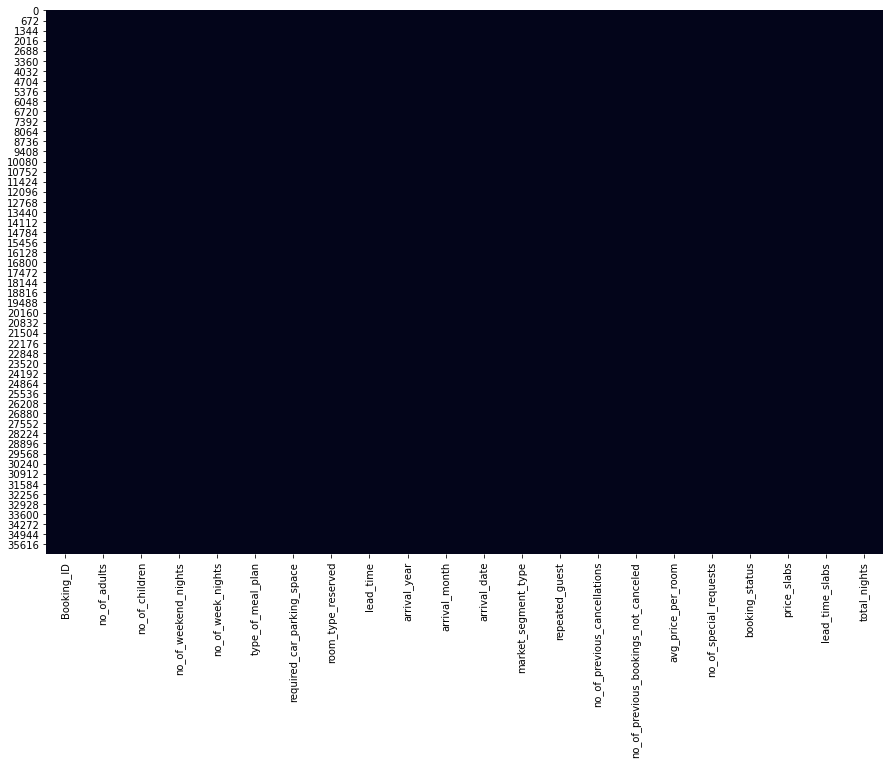

In [13]:
plt.figure(figsize=(15,10))
missing_plot = sns.heatmap(df.isnull(), cbar=False)
plt.savefig('missing_plot.jpg', dpi=400)
#There are no missing values as there are no white spots.

# EDA

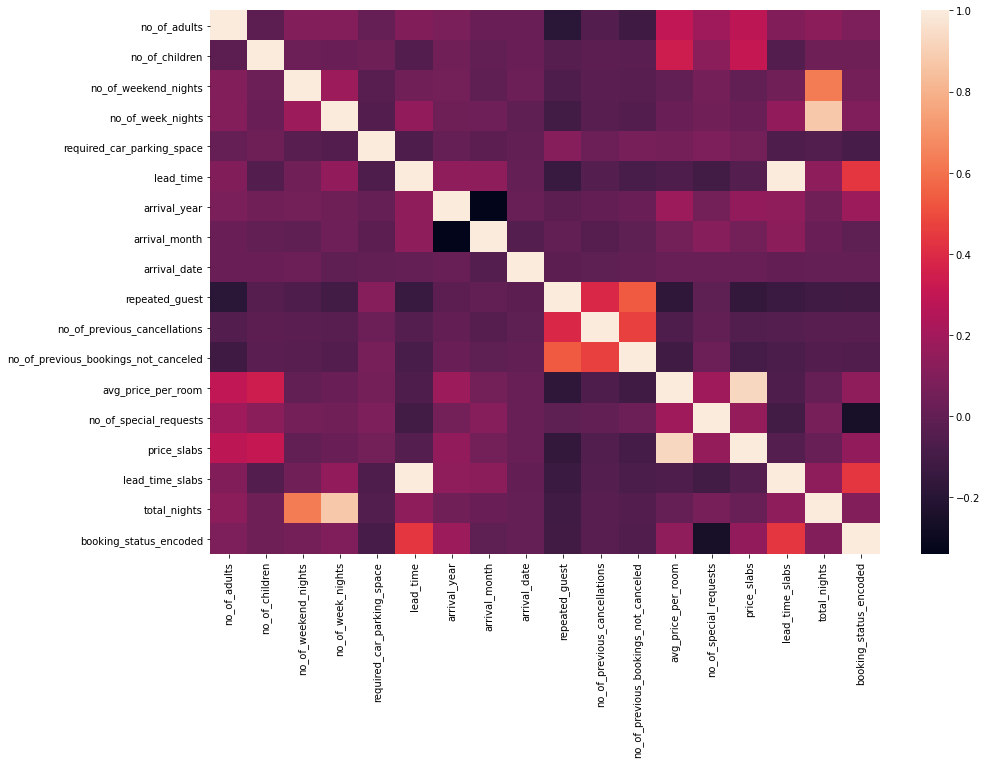

In [14]:
#Encoding the booking_status column so that it can have integer values. This will now be included in the sns correlation heatmap.
booking_status_encoded = []
for i in range(len(df)):
    if df.iloc[i,18] == 'Not_Canceled':
        booking_status_encoded.append(0)
    else:
        booking_status_encoded.append(1)
        
df_encoded = df.copy()
df_encoded['booking_status_encoded'] = booking_status_encoded

plt.figure(figsize=(15,10))
sns.heatmap(df_encoded.corr())
plt.show()

We can see that the booking status has comparitively high correlation with the lead time. This can be critical in classifiation model. 

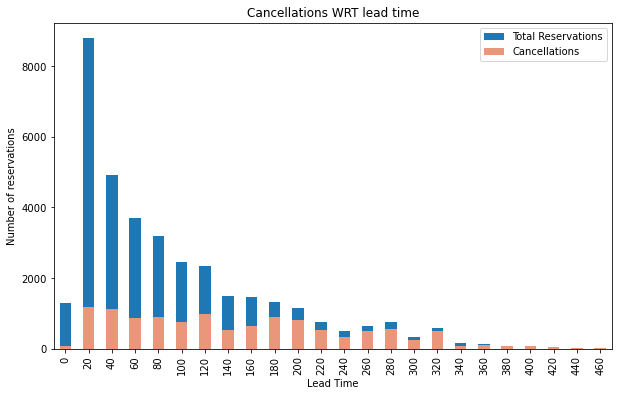

In [15]:
plt.figure(figsize=(10,6))

df['lead_time_slabs'].value_counts().sort_index().plot.bar()
df[df['booking_status']=='Canceled'].lead_time_slabs.value_counts().sort_index().plot.bar(color=['darksalmon'])

plt.title("Cancellations WRT lead time")
plt.legend(["Total Reservations", "Cancellations"])
plt.xlabel("Lead Time")
plt.ylabel("Number of reservations")

plt.show()

We can see that the cancellations increase with respect to lead time. As the lead time increases, we can see that the concentration of cancellations gets higher.

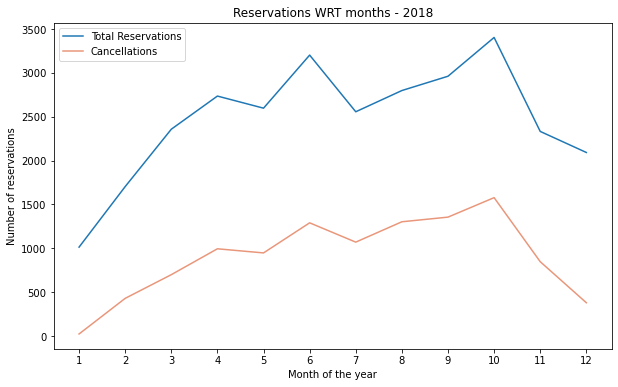

In [16]:
plt.figure(figsize=(10,6))

df[df['arrival_year']!=2017].arrival_month.value_counts(sort=False).plot.line()
df[df['booking_status']=='Canceled'][df['arrival_year']!=2017].arrival_month.value_counts().sort_index().plot.line(color=['darksalmon'])
#I have only included reservations made in 2018 as the reservaitons data is lower in the year 2018.  
plt.xticks(df['arrival_month'].value_counts(sort=False).index)
plt.title("Reservations WRT months - 2018")
plt.xlabel("Month of the year")
plt.ylabel("Number of reservations")
plt.legend(["Total Reservations", "Cancellations"])

plt.show()

The reservations are clearly lower in winter months and higher in summer months. For this hotel, the month wit highest reservations is october. 

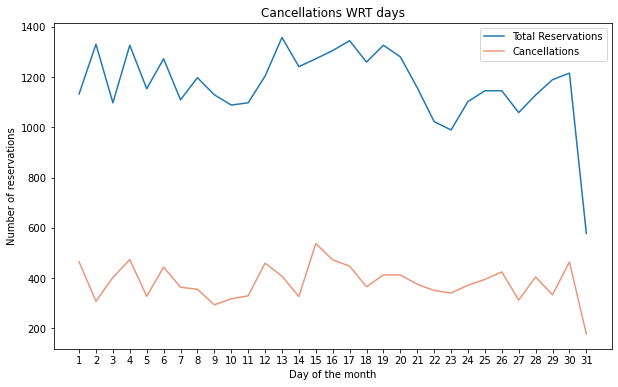

In [17]:
plt.figure(figsize=(10,6))

df['arrival_date'].value_counts(sort=False).sort_index().plot.line()
df[df['booking_status']=='Canceled'].arrival_date.value_counts().sort_index().plot.line(color=['darksalmon'])

plt.xticks(df[df['booking_status']=='Canceled'].arrival_date.value_counts().sort_index().index)
plt.title("Cancellations WRT days")
plt.xlabel("Day of the month")
plt.ylabel("Number of reservations")
plt.legend(["Total Reservations", "Cancellations"])

plt.show()

No clear information can be retrieved from this graph, the data is all over the place.

In [18]:
#While trying to plot reservations WRT days, the plot was showing days which were not in order as the data was not in datetime.
#So I have created a new day[] array containing the days of reservations. 
day=[]
for i in range(len(df)):
    if df.iloc[i,11] == 29:
        day.append('Friday')
    else:
        x=str(df.iloc[i,11]) + str("-") + str(df.iloc[i,10]) + str("-") + str(df.iloc[i,9])
        day.append(calendar.day_name[datetime.datetime.strptime(x, '%d-%m-%Y').weekday()])
    
df['day_of_week'] = day
data = [['Monday',5210],['Tuesday',4745],['Wednesday',5021],['Thursday',4434],['Friday',5727],['Saturday',5208],['Sunday',5930]]

<Figure size 720x432 with 0 Axes>

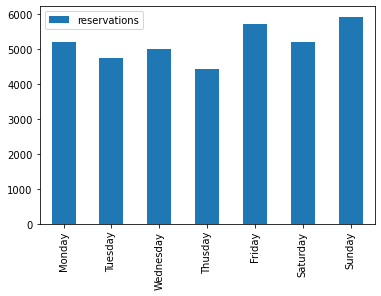

In [19]:
plt.figure(figsize=(10,6))
pd.DataFrame(data, columns = ['Day', 'reservations'], index =["Monday", "Tuesday", "Wednesday", "Thusday", "Friday","Saturday","Sunday"]).plot.bar()
plt.show()

We can see that the weekends get higher reservations than the week days. This is standard accorss the hospitalization industry. For some hotels, the differrence between weekdays and weekends is higher, but for this hotel the difference is lower. This could be due to the higher than normal number of reservations on week days.

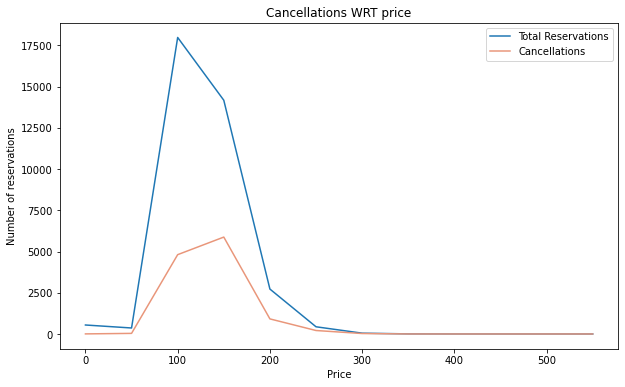

In [20]:
plt.figure(figsize=(10,6))

df['price_slabs'].value_counts().sort_index().plot.line()
df[df['booking_status']=='Canceled'].price_slabs.value_counts().sort_index().plot.line(color=['darksalmon'])

plt.title("Cancellations WRT price")
plt.legend(["Total Reservations", "Cancellations"])
plt.xlabel("Price")
plt.ylabel("Number of reservations")

plt.show()

We can see that the number of reservations are when the prices are arounf $100. We can also see that the percentage of reservations cancelled are least for this price as well. As the price increases, the reservations are very low and also the cancellaitons percentage are higher as well.

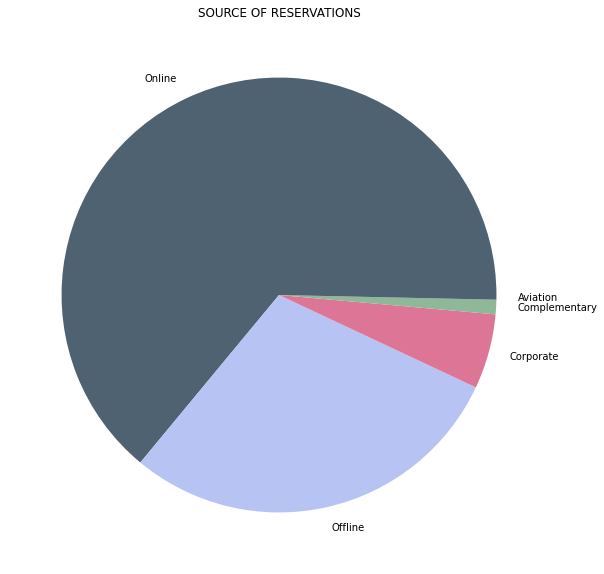

In [21]:
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

plt.figure(figsize=(15,10))

plt.pie(df['market_segment_type'].value_counts().array, labels = df['market_segment_type'].value_counts().to_frame().index.array, colors=colors)
plt.title("SOURCE OF RESERVATIONS")

plt.show()
#This shows that online reservations are more prevalent

Most of the reservations the hotel got are from online followed by offline. There are considerable reservations from corporate and complementary as well. The number of reservations from aviation are comparitively very low.

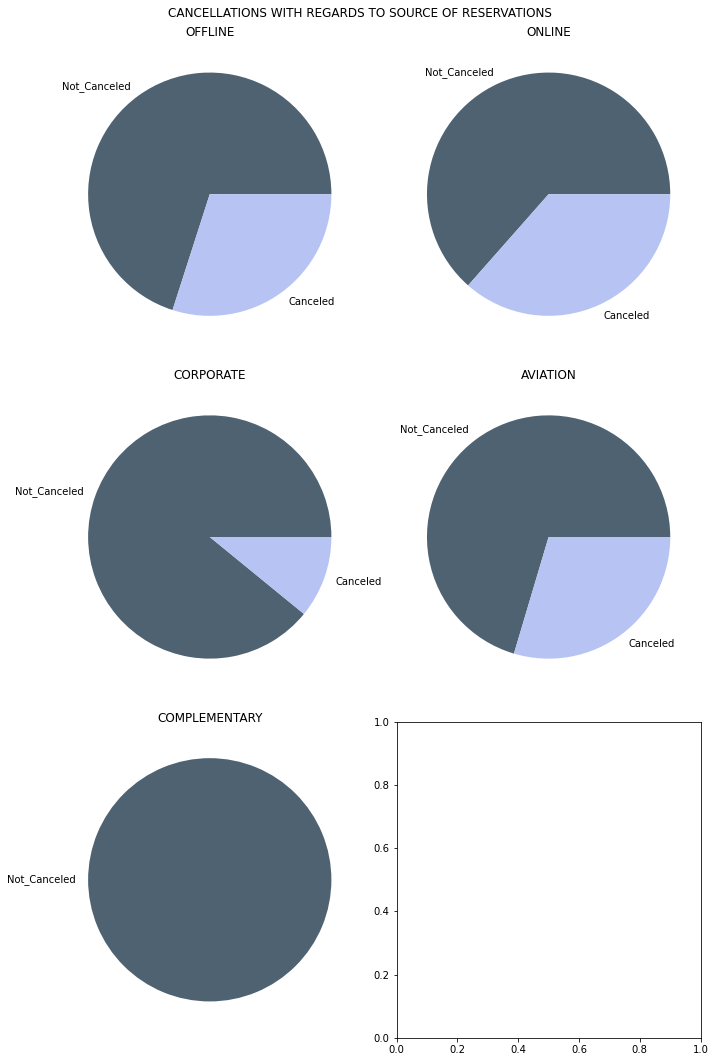

In [22]:
segments = df.groupby(['market_segment_type']).booking_status.value_counts()
segments_type = df['market_segment_type'].unique()

fig, axs = plt.subplots(3,2, figsize=(10,15))
fig.suptitle("Cancellations with regards to source of reservations".upper())
count=0
for i in range(3):
    for j in range(2):
        axs[i,j].pie(segments[segments_type[count]].values, labels=segments[segments_type[count]].index.array, colors=colors)
        axs[i,j].set_title(segments_type[count].upper())
        count+=1
        if count == 5:
            break
fig.tight_layout()
#Reservations from online and aviation have a high chance of getting canceled.

As we can see from the pie charts, the percentage of reservations canceled is higher for reservations made online. This can be due to the fact that online reservations have easy cancellaiton policies which enable the guest to cancel their reservations at ther will. Both the sources of reservations, offline and aviation, have similar percentage of reservations canceled. The reservations which come from corporate have less chance of getting canceled. All the reservaitons from complementary are fulfiled. 

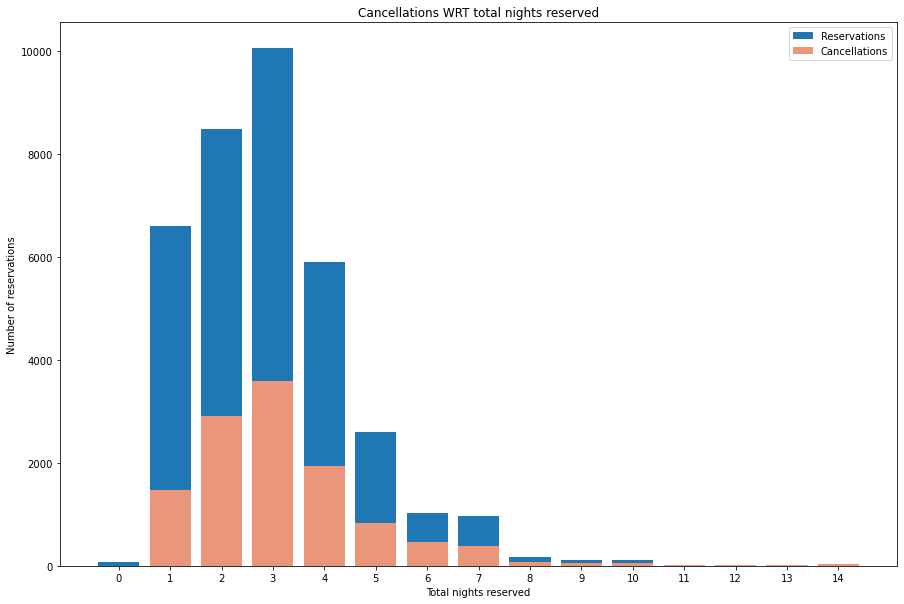

In [23]:
a = df[df['total_nights']<11].total_nights.value_counts(sort=False).head(15)
b = df[df['booking_status']=='Canceled'].total_nights.value_counts(sort=False).sort_index().head(15)

plt.figure(figsize=(15,10))

plt.bar(a.index, a.values, label='Reservations')
plt.bar(b.index, b.values, color = 'darksalmon',label='Cancellations')

plt.title("Cancellations WRT total nights reserved")
plt.xlabel("Total nights reserved")
plt.ylabel("Number of reservations")
plt.legend()
plt.xticks(b.index)
plt.legend()

plt.show()

#most of the guests reserved to stay for 3 nights in the hotel.

Most of the guests reserved for arounf 3 nights and we can see that as the number of nights reserved increases, the chance of a reservaiton getting cancelled increases as well.

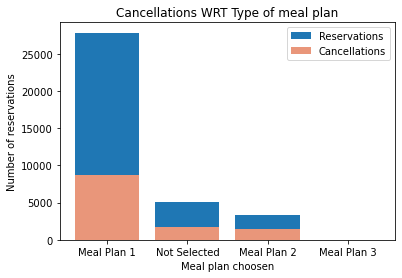

In [24]:
c = df['type_of_meal_plan'].value_counts()
d= df[df['booking_status']=='Canceled'].type_of_meal_plan.value_counts()

plt.bar(c.index, c.values, label='Reservations')
plt.bar(d.index, d.values, color = 'darksalmon',label='Cancellations')

plt.title("Cancellations WRT Type of meal plan")
plt.xlabel("Meal plan choosen")
plt.ylabel("Number of reservations")
plt.legend()

plt.show()
#Not usefull

We can see that if a guest chooses a meal-plan 1, he/she is less likely to cancel the reservation.

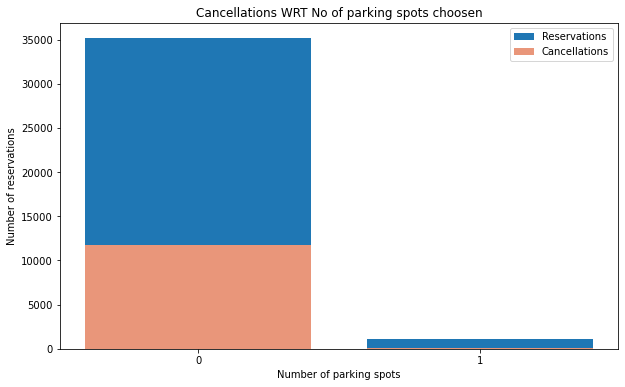

In [25]:
e = df['required_car_parking_space'].value_counts()
f= df[df['booking_status']=='Canceled'].required_car_parking_space.value_counts()

plt.figure(figsize=(10,6))

plt.bar(e.index, e.values, label='Reservations')
plt.bar(f.index, f.values, color = 'darksalmon',label='Cancellations')

plt.title("Cancellations WRT No of parking spots choosen")
plt.xticks(df['required_car_parking_space'].value_counts().index)
plt.xlabel("Number of parking spots")
plt.ylabel("Number of reservations")
plt.legend()

plt.show()
#Reservations with one parking spot have less chance of getting cancelled

This is a very interesting plot, we can see that the concentration of orange is less for 1 parking spot. This means that if a guest chooses a parking spot, they are less likely to cancel the reservation. This can be due to the fact that if a guest chooses a parking spot, he/she is serious about their stay and may not cancel.

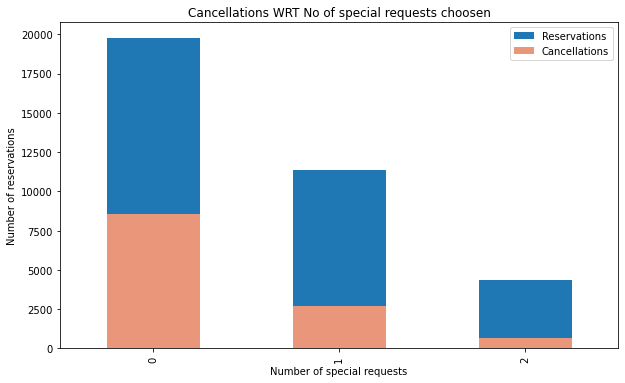

In [26]:
plt.figure(figsize=(10,6))

e = df['no_of_special_requests'].value_counts().plot.bar(label='Reservations')
f= df[df['booking_status']=='Canceled'].no_of_special_requests.value_counts().plot.bar(color='darksalmon', label='Cancellations')

#plt.line(e.index, e.values, color = 'darkturquoise',label='Reservations')
#plt.line(f.index, f.values, color = 'darksalmon',label='Cancellations')

plt.xticks(df[df['booking_status']=='Canceled'].no_of_special_requests.value_counts().index)
plt.title("Cancellations WRT No of special requests choosen")
plt.xlabel("Number of special requests")
plt.ylabel("Number of reservations")
plt.legend()

plt.show()
#Reservations with high number of special requests less chance of getting cancelled

We can see that as the number of special requests increases, the chance of a reservaiton getting cancelled decreases this can again be due to the fact that guests would most porbably make special requests if they are serious about thier stay.

# Classification

## Logistic Regression

In [27]:
numerics = ['int16', 'int32', 'int64','float64']
non_numerics = ['object']

numerical_vars = df.select_dtypes(include=numerics).columns 
categorical_Vars = df.select_dtypes(include=non_numerics).columns
#Seperating numerical and categorical variables

In [28]:
unwanted = {'Booking_ID','booking_status'}
# I have choose keep rest of the features. 
 
numerical_list = [ele for ele in numerical_vars if ele not in unwanted]
categorical_list = [ele for ele in categorical_Vars if ele not in unwanted]

#Removing unwanted column and target variable from the lists and creating final numerical and cetegorical lists

In [29]:
#Printing out the final numerical and categorical lists
print("Numerical variables:",', '.join(numerical_list),'\n')
print("Categorical variables:",', '.join(categorical_list))

Numerical variables: no_of_adults, no_of_children, no_of_weekend_nights, no_of_week_nights, required_car_parking_space, lead_time, arrival_year, arrival_month, arrival_date, repeated_guest, no_of_previous_cancellations, no_of_previous_bookings_not_canceled, avg_price_per_room, no_of_special_requests, price_slabs, lead_time_slabs, total_nights 

Categorical variables: type_of_meal_plan, room_type_reserved, market_segment_type, day_of_week


In [30]:
from sklearn.model_selection import train_test_split

#Deifining a splitting function with test to train sample ratio of 20:80% and a random state of 124 to ensure same results.
def generate_splits():
    y = df['booking_status']
    X = df[[x for x in df.columns if x != 'booking_status']]

    return train_test_split(X, y, test_size=0.2, random_state=124)

X_train, X_test, y_train, y_test = generate_splits()

#printing the size of train and test datasets
print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 29,020
Test examples: 7,255


In [31]:
#defining a numerical pipeline with standard scaler which standardizes the features of the data
num_pipeline = Pipeline([('standardize_num', StandardScaler())])

#defiing a categorical pipeline with one hot encoder which encodes the data into integer values
cat_pipeline = Pipeline([('create_dummies_cats', OneHotEncoder(handle_unknown='error', drop='first'))])


#merging both numerical and categorical pipelines into one processing pipeline.
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_list),
                                                      ('create_dummies', cat_pipeline, categorical_list)])


#Creating a logistic regression pipeline which manages the data and also applies logistic regression classifier on the data
lr_pipeline = Pipeline([('data_processing', processing_pipeline),
                              ('pca', PCA(n_components=5)),
                              ('logreg', LogisticRegression(penalty='l2', max_iter = 1000))])
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

In [ ]:
num_pipeline = Pipeline([('standardize_num', StandardScaler())])

cat_pipeline = Pipeline([('create_dummies_cats', OneHotEncoder(handle_unknown='error', drop='first'))])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_list),
                                                      ('create_dummies', cat_pipeline, categorical_list)])

In [32]:
#Using gridsearchcv and fitting the data with training dataset
#Primary grid search
%timeit 

parameters = {'logreg__C':[0.01,1.0,5.0,10]} 

logistic_reg = GridSearchCV(lr_pipeline, param_grid = parameters, scoring='accuracy', cv = 5, refit = True, verbose = 10) 
logistic_reg = logistic_reg.fit(X_train, y_train)

logistic_reg.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START logreg__C=0.01..............................................
[CV 1/5; 1/4] END ...............logreg__C=0.01;, score=0.756 total time=   0.1s
[CV 2/5; 1/4] START logreg__C=0.01..............................................
[CV 2/5; 1/4] END ...............logreg__C=0.01;, score=0.755 total time=   0.1s
[CV 3/5; 1/4] START logreg__C=0.01..............................................
[CV 3/5; 1/4] END ...............logreg__C=0.01;, score=0.762 total time=   0.1s
[CV 4/5; 1/4] START logreg__C=0.01..............................................
[CV 4/5; 1/4] END ...............logreg__C=0.01;, score=0.762 total time=   0.1s
[CV 5/5; 1/4] START logreg__C=0.01..............................................
[CV 5/5; 1/4] END ...............logreg__C=0.01;, score=0.761 total time=   0.1s
[CV 1/5; 2/4] START logreg__C=1.0...............................................
[CV 1/5; 2/4] END ................logreg__C=1.0;,

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

In [33]:
#Performing a secondary search with different parameter values
parameters = {'logreg__C':[10,12,15,16,20]} 

logistic_reg_2 = GridSearchCV(lr_pipeline, param_grid = parameters, scoring='accuracy', cv = 5, refit = True, verbose = 10) 
logistic_reg_2 = logistic_reg_2.fit(X_train, y_train)

logistic_reg_2.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START logreg__C=10................................................
[CV 1/5; 1/5] END .................logreg__C=10;, score=0.758 total time=   0.1s
[CV 2/5; 1/5] START logreg__C=10................................................
[CV 2/5; 1/5] END .................logreg__C=10;, score=0.757 total time=   0.1s
[CV 3/5; 1/5] START logreg__C=10................................................
[CV 3/5; 1/5] END .................logreg__C=10;, score=0.766 total time=   0.1s
[CV 4/5; 1/5] START logreg__C=10................................................
[CV 4/5; 1/5] END .................logreg__C=10;, score=0.763 total time=   0.1s
[CV 5/5; 1/5] START logreg__C=10................................................
[CV 5/5; 1/5] END .................logreg__C=10;, score=0.761 total time=   0.1s
[CV 1/5; 2/5] START logreg__C=12................................................
[CV 1/5; 2/5] END .................logreg__C=12;,

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

In [34]:
#obtianing a classification report using predicted values
y_hat = logistic_reg_2.predict(X_test)
    
print(classification_report(y_test, y_hat))
#Logistic Regression model with 77% accuracy

              precision    recall  f1-score   support

    Canceled       0.72      0.49      0.58      2395
Not_Canceled       0.78      0.90      0.84      4860

    accuracy                           0.77      7255
   macro avg       0.75      0.70      0.71      7255
weighted avg       0.76      0.77      0.75      7255



In [35]:
print("The score of this logistic regression model is :",logistic_reg_2.score(X_test, y_test))

The score of this logistic regression model is : 0.7676085458304618


In [36]:
print(confusion_matrix(y_test, y_hat))

[[1176 1219]
 [ 467 4393]]


This model has pipeline which pre-processes the data using standard scaler and one hot encoder. It then applies logistic regression classifier on the data and also has two levels of hyperparameter searching done using GridSearchCV. This model has an accuracy of 0.77. The accuracy might seem desirable but still can get better. The precision, recall and f1-score values are higher while predicting "Not_Canceled" but very low while predicting "Canceled". This model is incomplete and should not be used unless there is no other alternative.

#### ROC-AUC Curve

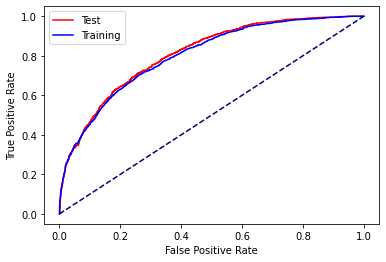

In [37]:
def generate_probs_1(X, model=logistic_reg_2):
    return model.predict_proba(X)[:, 1]

def generate_roc_1(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr
 
y_test_ROC = y_test.map({'Canceled':0, 'Not_Canceled':1}).astype(int)
y_train_ROC = y_train.map({'Canceled':0, 'Not_Canceled':1}).astype(int)

fpr_test, tpr_test = generate_roc_1(y_test_ROC, generate_probs_1(X_test))
fpr_train, tpr_train = generate_roc_1(y_train_ROC, generate_probs_1(X_train))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [38]:
roc_auc_score(y_test, generate_probs_1(X_test))

0.8094111961648496

AUC-ROC curve is a performance measurement for the classification problems at various threshold settings. A good model has AUC near 1, whihc means that the model can clearly predict values 0 and 1. In the above plot, we can see that the curve is not pefectly right angled, but a little bent in shape. The ROC-AUC score of the model came out to be 0.80 which is quite favourable for a classifier but not the perfect one. 

## Decision Tree

In [39]:
#Deinfing a pipeine whihc used the previos preporcessing pipeline and decision tree classifier
modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('dt', DecisionTreeClassifier())]
)

#defining parameters for the grid search
#this is the primary grid sarch
param_grid = [
  {'dt__max_depth': [2, 5, 10, 15, 20],
   'dt__min_samples_split':[3, 5, 10, 20, 40],
   'dt__min_samples_leaf': [2, 5],
   'dt__class_weight':[None, 'balanced']
  }
 ]

dt_results = GridSearchCV(estimator=modeling_pipeline, 
                           param_grid=param_grid, scoring='accuracy', refit=True)
dt_results = dt_results.fit(X_train, y_train)

#best_estimator_ gives the best estimator choosen by the search.
dt_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

In [40]:
#secondary grid search with updates values
param_grid = [
  {'dt__max_depth': [15, 16, 19, 20, 25],
   'dt__min_samples_split':[3, 5, 10, 20, 40],
   'dt__min_samples_leaf': [5, 10],
   'dt__class_weight':[None, 'balanced']
  }
 ]

dt_results_2 = GridSearchCV(estimator=modeling_pipeline, 
                           param_grid=param_grid, scoring='accuracy', refit=True)
dt_results_2 = dt_results_2.fit(X_train, y_train)

dt_results_2.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

This estimator is better than the last one. The parameters from the secondary grid search are final. 

In [41]:
#obtianing a classification report using predicted values
y_testp = dt_results_2.predict(X_test)

print(classification_report(y_test, y_testp))
#Decision tree classifier with an accuracy of 0.88

              precision    recall  f1-score   support

    Canceled       0.83      0.79      0.81      2395
Not_Canceled       0.90      0.92      0.91      4860

    accuracy                           0.88      7255
   macro avg       0.86      0.86      0.86      7255
weighted avg       0.88      0.88      0.88      7255



In [42]:
print(confusion_matrix(y_test, y_testp))

[[1903  492]
 [ 403 4457]]


This model has pipeline which pre-processes the data using standard scaler and one hot encoder. It then applies decision tree classifier on the data and also has two levels of hyperparameter searching done using GridSearchCV. This model has an accuracy of 88%. This model also has good precision recall and f-score values while prediciting both 'canceled' and 'not_canceled' values but its ability to correctly predict "not_canceled" values is higher than to predict "canceled" . This is better than the logistic regression conducted before in terms of accuracy, precision and recall values. The run time of this classifier is also pretty low compared to other models like Random forest and Grdient boosting classifiers. The "dt_results_2" is the final model with the best estimator.

#### ROC-AUC Curve

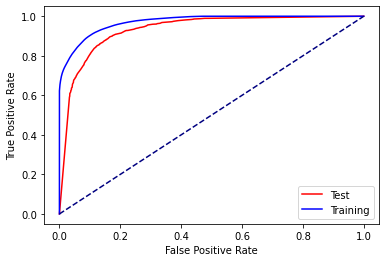

In [43]:
from sklearn.metrics import roc_curve

def generate_probs_2(X, model=dt_results_2):
    return model.predict_proba(X)[:, 1]

def generate_roc_2(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr
 
y_test_ROC = y_test.map({'Canceled':0, 'Not_Canceled':1}).astype(int)
y_train_ROC = y_train.map({'Canceled':0, 'Not_Canceled':1}).astype(int)

fpr_test, tpr_test = generate_roc_2(y_test_ROC, generate_probs_2(X_test))
fpr_train, tpr_train = generate_roc_2(y_train_ROC, generate_probs_2(X_train))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [44]:
print("The ROC-AOC score of this model is",roc_auc_score(y_test, generate_probs_2(X_test)))

The ROC-AOC score of this model is 0.9319893983521911


This model also has better ROC-AOC score than the first model. Which means that the model is better equipped to identify and seperate the two classes. This model can be viable if the accuracy does not increase in the futher models.

## Random Forest

In [45]:
#Creating a random forest pipeline with data processing pipeline from the previous steps and using rendom forest classifier.
rf_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('rf', RandomForestClassifier())]
)

#choosing parameters for hyper parameter searching
#this is primary serach
param_grid = [{'rf__max_depth': [5, 8, 10, 12],
               'rf__n_estimators': [10, 50, 100],
               'rf__class_weight': [None, 'balanced', 'balanced_subsample'],
               'rf__max_samples': [1000, 2000, 5000]
              }]

rf_results = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, scoring='accuracy', refit=True)
rf_results = rf_results.fit(X_train, y_train)
rf_yhat = rf_results.predict(X_test)

#getting the best estimator
rf_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

In [46]:
#definind the parameters for secondary hyperparameter searching
param_grid = [{'rf__max_depth': [12, 13, 17, 20],
               'rf__n_estimators': [50, 100, 120],
               'rf__class_weight': [None, 'balanced', 'balanced_subsample'],
               'rf__max_samples': [5000, 7000, 9000]
              }]

rf_results_2 = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, scoring='accuracy', refit=True)
rf_results_2 = rf_results_2.fit(X_train, y_train)

#getting the best estimator for the secondary grid search
rf_results_2.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

In [47]:
#predicting using the best random forest model
rf_yhat = rf_results_2.predict(X_test)

print(classification_report(y_test, rf_yhat))

              precision    recall  f1-score   support

    Canceled       0.88      0.79      0.83      2395
Not_Canceled       0.90      0.95      0.92      4860

    accuracy                           0.89      7255
   macro avg       0.89      0.87      0.88      7255
weighted avg       0.89      0.89      0.89      7255



In [48]:
print(confusion_matrix(y_test, rf_yhat))

[[1886  509]
 [ 254 4606]]


This model has an accuracy of 90%. The precision, recall and f1 values of the model are pretty good as well. Though these values are greater while prediting "Not-canceled" just like all the other models, the values while predicting "Canceled" are good as well. This model has the highest accuracy of the three models that are analysed until now. This model is chosen after tuning the hyperparameter search with secondary grid search technique to create the best model. Considering that this model took same amount of time to run as the decision tree model, this model is dar supirior with higher accuracy. 

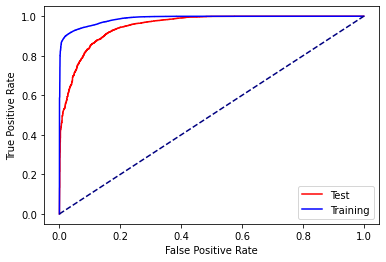

In [49]:
#getting the ROC curve
def generate_probs_3(X, model=rf_results_2):
    return model.predict_proba(X)[:, 1]

def generate_roc_3(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr
 
y_test_ROC = y_test.map({'Canceled':0, 'Not_Canceled':1}).astype(int)
y_train_ROC = y_train.map({'Canceled':0, 'Not_Canceled':1}).astype(int)

fpr_test, tpr_test = generate_roc_3(y_test_ROC, generate_probs_3(X_test))
fpr_train, tpr_train = generate_roc_3(y_train_ROC, generate_probs_3(X_train))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [50]:
print("The ROC-AUC score of this model is",roc_auc_score(y_test, generate_probs_3(X_test)))

The ROC-AUC score of this model is 0.9517859137262988


This model has better ROC curve as well. Compared to the previous model's ROC score of 0.93, this model has better ROC score with 0.95. This means that this model can differentiate well between the two classes. Hence this model is by far the better model of all.

## Gradient Boosting

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

#creating a pipeline that consists of data processing pipeline that was assigned before and a gradient boosting classifier.
gb_pipeline = Pipeline([('data_processing', processing_pipeline),
                        ('gbc', GradientBoostingClassifier())])


#Defining the parameters for grid search
params = [{'gbc__max_depth': [5, 8, 20],
               'gbc__n_estimators': [50, 70, 100]
              }]

gb_results = GridSearchCV(gb_pipeline,
                         param_grid = params, cv = 5,
                         scoring = 'accuracy', verbose = 10)

gb_results = gb_results.fit(X_train, y_train)

#Finding the best estimator
gb_results.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START gbc__max_depth=5, gbc__n_estimators=50......................
[CV 1/5; 1/9] END gbc__max_depth=5, gbc__n_estimators=50;, score=0.869 total time=   2.8s
[CV 2/5; 1/9] START gbc__max_depth=5, gbc__n_estimators=50......................
[CV 2/5; 1/9] END gbc__max_depth=5, gbc__n_estimators=50;, score=0.875 total time=   2.9s
[CV 3/5; 1/9] START gbc__max_depth=5, gbc__n_estimators=50......................
[CV 3/5; 1/9] END gbc__max_depth=5, gbc__n_estimators=50;, score=0.873 total time=   2.6s
[CV 4/5; 1/9] START gbc__max_depth=5, gbc__n_estimators=50......................
[CV 4/5; 1/9] END gbc__max_depth=5, gbc__n_estimators=50;, score=0.868 total time=   2.2s
[CV 5/5; 1/9] START gbc__max_depth=5, gbc__n_estimators=50......................
[CV 5/5; 1/9] END gbc__max_depth=5, gbc__n_estimators=50;, score=0.867 total time=   2.2s
[CV 1/5; 2/9] START gbc__max_depth=5, gbc__n_estimators=70......................
[CV 

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

In [52]:
#Performing a secondary grid search for better results
params = [{'gbc__max_depth': [8, 10, 20],
               'gbc__n_estimators': [100, 120, 150]
              }]

gb_results_2 = GridSearchCV(gb_pipeline,
                         param_grid = params, cv = 5,
                         scoring = 'accuracy', verbose = 10)

gb_results_2 = gb_results_2.fit(X_train, y_train)

#Finding the best estimator
gb_results_2.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START gbc__max_depth=8, gbc__n_estimators=100.....................
[CV 1/5; 1/9] END gbc__max_depth=8, gbc__n_estimators=100;, score=0.897 total time=   7.5s
[CV 2/5; 1/9] START gbc__max_depth=8, gbc__n_estimators=100.....................
[CV 2/5; 1/9] END gbc__max_depth=8, gbc__n_estimators=100;, score=0.902 total time=   7.4s
[CV 3/5; 1/9] START gbc__max_depth=8, gbc__n_estimators=100.....................
[CV 3/5; 1/9] END gbc__max_depth=8, gbc__n_estimators=100;, score=0.895 total time=   7.4s
[CV 4/5; 1/9] START gbc__max_depth=8, gbc__n_estimators=100.....................
[CV 4/5; 1/9] END gbc__max_depth=8, gbc__n_estimators=100;, score=0.891 total time=   7.4s
[CV 5/5; 1/9] START gbc__max_depth=8, gbc__n_estimators=100.....................
[CV 5/5; 1/9] END gbc__max_depth=8, gbc__n_estimators=100;, score=0.890 total time=   7.6s
[CV 1/5; 2/9] START gbc__max_depth=8, gbc__n_estimators=120.....................

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('standardize_num',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time', 'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellat

In [53]:
gb_yhat = gb_results_2.predict(X_test)

print(classification_report(y_test, gb_yhat))

              precision    recall  f1-score   support

    Canceled       0.87      0.82      0.84      2395
Not_Canceled       0.91      0.94      0.93      4860

    accuracy                           0.90      7255
   macro avg       0.89      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255



In [54]:
print(confusion_matrix(y_test, gb_yhat))

[[1969  426]
 [ 298 4562]]


This model got an accuracy of 90%. This is a pretty good score for this model. The precision, recall and f1-score values are good as well. Compared to the current best model, Random forest, this model took around 15 minutes to run, for a dataset of this size, this model takes huge computational power to execute, which is not desirable unless it has a very high accuracy or precision values. 

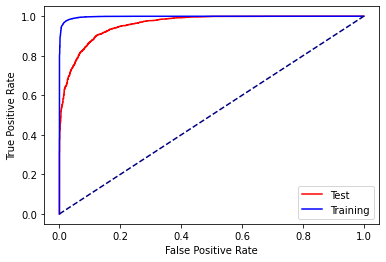

In [55]:
from sklearn.metrics import roc_curve

def generate_probs_4(X, model=gb_results_2):
    return model.predict_proba(X)[:, 1]

def generate_roc_4(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr
 
y_test_ROC = y_test.map({'Canceled':0, 'Not_Canceled':1}).astype(int)
y_train_ROC = y_train.map({'Canceled':0, 'Not_Canceled':1}).astype(int)

fpr_test, tpr_test = generate_roc_4(y_test_ROC, generate_probs_4(X_test))
fpr_train, tpr_train = generate_roc_4(y_train_ROC, generate_probs_4(X_train))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [56]:
print("The ROC-AUC score of this model is",roc_auc_score(y_test, generate_probs_4(X_test)))

The ROC-AUC score of this model is 0.9596487452425749


The ROC score of this model is 0.95 which is similar to that of random forest. Due to the computational effort to run this model and the similar accuracy wiht the less demanding random forest classifier, this model is not prefered for this usecase. 

### Conclusion - Choosing the best model

Comparing all the models:

#### Logistic Regression

In [57]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

    Canceled       0.72      0.49      0.58      2395
Not_Canceled       0.78      0.90      0.84      4860

    accuracy                           0.77      7255
   macro avg       0.75      0.70      0.71      7255
weighted avg       0.76      0.77      0.75      7255



#### Decision Tree

In [58]:
print(classification_report(y_test, y_testp))

              precision    recall  f1-score   support

    Canceled       0.83      0.79      0.81      2395
Not_Canceled       0.90      0.92      0.91      4860

    accuracy                           0.88      7255
   macro avg       0.86      0.86      0.86      7255
weighted avg       0.88      0.88      0.88      7255



#### Random Forest

In [59]:
print(classification_report(y_test, rf_yhat))

              precision    recall  f1-score   support

    Canceled       0.88      0.79      0.83      2395
Not_Canceled       0.90      0.95      0.92      4860

    accuracy                           0.89      7255
   macro avg       0.89      0.87      0.88      7255
weighted avg       0.89      0.89      0.89      7255



#### Gradient Boosting

In [60]:
print(classification_report(y_test, gb_yhat))

              precision    recall  f1-score   support

    Canceled       0.87      0.82      0.84      2395
Not_Canceled       0.91      0.94      0.93      4860

    accuracy                           0.90      7255
   macro avg       0.89      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255



I have choosed Gradient Boosting classifier as the two classifiers I have tried, K Nearest Neighbours and Support Vector Machine, were not running on my laptop. I have waited for more than 5 hours with no success. I expect those two classifiers to have a similar accuracy to my other model, but even if they managed to run successfully, they would have used a lot of computational power, hence would not make sense to use them for this dataset.

Last two models, Random Forest and gradient boosting technique are the best models for this dataset. They both have similar accuracies at 90% but gradient boosting takes a lot of time to run compared to other models.

Out of all the 4 models that have been anlaysed for this dataset, I would choose the model that used Random Forest classifier for predicting the values. The gradient boosting technique also has good accuracy and precision values but the computational power needed to run this technique is high, therefore random forest classifier is better to predict the unknown features in this case. 

Hotel reservtions get cancelled for many reasons, but this aims to find those reservations made by guests who are not certain about their stay. This model can identify those reservations accurately. This can help the hotel get a clear idea of the demand and also potentially forecast income.

## References

https://github.com/appliedecon/data602-lectures/blob/main/logistic-regression/logistic-regression.ipynb

https://github.com/appliedecon/data602-lectures/blob/main/model-evaluation/model-evaluation.ipynb

https://github.com/appliedecon/data602-lectures/blob/main/trees/trees.ipynb

https://github.com/appliedecon/data602-lectures/blob/main/supervised-algorithms/knn-nb-svm.ipynb

https://github.com/appliedecon/data602-lectures/blob/main/ensembles/ensembles.ipynb

https://github.com/appliedecon/data602-lectures/blob/main/dimension-reduction/dimension-reduction.ipynb